In [1]:
%cd ..
%matplotlib nbagg

/home/elias/work/generative-scattering-networks


In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Resize
from tqdm import tqdm

from generator_architecture import Generator, weights_init
from datasets import EmbeddingsTransformDataset
from utils import uint8_image, create_name_experiment
from config import DATASETS_PATH

In [126]:
parameters = dict()
parameters['image_size'] = 128

parameters['dataset'] = 'celeba_hq'
parameters['dataset_attribute'] = '1024_rgb'
parameters['dim'] = 200
parameters['embedding_attribute'] = 'SJ4_PCA_{}'.format(parameters['dim'])

parameters['nb_channels_first_layer'] = 64
parameters['size_first_layer'] = 4
parameters['num_channel'] = 3
parameters['linear_bias'] = True
parameters['conv_kernel'] = 5

parameters['name_experiment'] = create_name_experiment(parameters, 'test_overfitting')



gen = Generator(
        parameters['nb_channels_first_layer'],
        parameters['dim'],
        size_first_layer=4,
        num_channel=3,
        linear_bias=True,
        conv_kernel=5,
    )

Name experiment: celeba_hq_1024_rgb_SJ4_PCA_200_ncfl64_test_overfitting


In [27]:
dataset = parameters['dataset']
dataset_attribute = parameters['dataset_attribute']
embedding_attribute = parameters['embedding_attribute']

dir_datasets = Path(DATASETS_PATH).expanduser()
dir_x_train = dir_datasets / dataset / dataset_attribute / 'train'

dir_z_train = (
    dir_datasets / dataset
    / '{0}_{1}'.format(parameters['dataset_attribute'], parameters['embedding_attribute'])
    / 'train')

transorm = Compose([
            Resize((128, 128)),
            ToTensor(),
        ])

dataset_train = EmbeddingsTransformDataset(
    dir_z_train,
    dir_x_train,
    transorm)

In [28]:
data = dataset_train[0]
X, Z = data['x'], data['z']

<IPython.core.display.Javascript object>


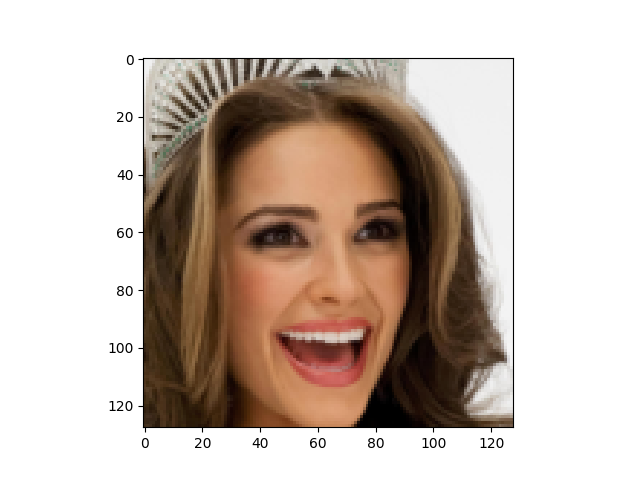

In [85]:
plt.figure()
plt.imshow(uint8_image(X.permute(1, 2, 0)))
plt.show()

In [127]:
gen.apply(weights_init)

Generator(
  (main): Sequential(
    (0): Linear(in_features=200, out_features=16384, bias=True)
    (1): View()
    (2): BatchNorm2d(1024, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvBlock(
      (pad): ReflectionPad2d((2, 2, 2, 2))
      (conv): Conv2d(1024, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (bn_layer): BatchNorm2d(512, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    )
    (5): ConvBlock(
      (pad): ReflectionPad2d((2, 2, 2, 2))
      (conv): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (bn_layer): BatchNorm2d(256, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    )
    (6): ConvBlock(
      (pad): ReflectionPad2d((2, 2, 2, 2))
      (conv): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (bn_layer): BatchNorm2d(128, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    )
    (7): ConvBlock(
      (pa

In [128]:
criterion = torch.nn.L1Loss()

optimizer = optim.Adam(gen.parameters())

In [129]:
batch_size = 1

batch_x = torch.stack([X]*batch_size, dim=0)
batch_z = torch.stack([torch.Tensor(Z)]*batch_size, dim=0)

In [134]:
epochs = 500
gen.train()
gen.cuda()

for e in range(1, epochs+1):
    gen.zero_grad()
    
    x = Variable(batch_x).float().cuda()
    z = Variable(batch_z).float().cuda()
    
    g_z = gen.forward(z)

    loss = criterion(g_z, x)
    loss.backward()
    optimizer.step()
    
    sys.stdout.write('Epoch : {}, Loss : {:2.4f}\r'.format(e, loss.item()))
    sys.stdout.flush()

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


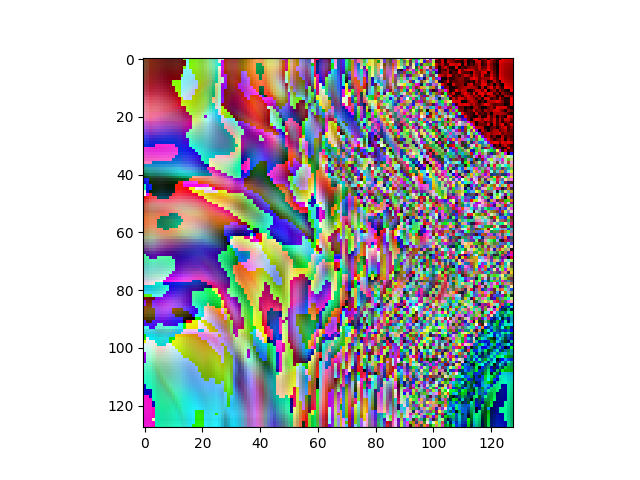

In [135]:
gen.eval()
with torch.no_grad():
    z = Variable(torch.Tensor(Z).unsqueeze(0)).float().cuda()
    g_z = gen.forward(z)
    
plt.figure()
plt.imshow(uint8_image(g_z.data[0].permute(1, 2, 0)))
plt.show()

In [125]:
Image.fromarray(uint8_image(g_z.data[0].permute(1, 2, 0))).save('tmp.png')